In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#import warnings
#warnings.filterwarnings('ignore')

import time
import threading

import numpy as np
import pandas as pd
from scipy.linalg import solve

import streamz as sz

from IPython.display import display, Markdown, Math
from sympy import Matrix, latex

from bokeh.models.widgets import HTMLTemplateFormatter
import param
import holoviews as hv; hv.extension("bokeh", "plotly", logo=False)
import panel as pn;     pn.extension()

from holoviews.streams import Buffer

<div style="float:center;width:100%;text-align: center;"><strong style="height:60px;color:darkred;font-size:40px;">Iterative Methods with Python</strong></div>

# 1. Code: Monitor the Evolution of an Iterative Scheme

In [2]:
class GraphicalMonitor:
    """Class to visualize iterates and error evolution step-by-step, with a final table display."""

    @staticmethod
    def _table_formatter2D(plot, element):
        """Custom table formatter for styling."""
        plot.handles['table'].columns[3].formatter = HTMLTemplateFormatter(
            template="""<div style="color:red;"><%= value ? value.toExponential(8) : value %></div>"""
        )

    def __init__(self, buffer_size=10, log_y=True):
        """
        Initialize the graphical monitor.

        Parameters:
        - buffer_size: Maximum number of points to store in the buffer.
        """
        hv.extension("bokeh", logo=False)
        # Buffers for solution and error
        self.solution_buffer = Buffer(pd.DataFrame({'x': [], 'y': []}), length=buffer_size)
        self.error_buffer = Buffer(pd.DataFrame({'step': [], 'error': []}), length=buffer_size)

        # Store results in a DataFrame
        self.results = pd.DataFrame(
            {'step': pd.Series(dtype='int'),
             'x': pd.Series(dtype='float'),
             'y': pd.Series(dtype='float'),
             'error': pd.Series(dtype='float')}
        )

        # Panel table for displaying results
        self.results_table = pn.panel(hv.Table(self.results.tail(10)).opts(  # Show the latest rows
            height=150,  # Adjusted height to show limited rows
            width=800,   # Adjusted width to match the updated plot sizes
            hooks=[self._table_formatter2D]  # Apply custom formatting
        ))

        # Create DynamicMaps for solution and error plots
        self.solution_plot = hv.DynamicMap(self._plot_solution, streams=[self.solution_buffer])
        self.error_plot = hv.DynamicMap(self._plot_error, streams=[self.error_buffer])

        # Combine the plots and the table in a layout
        self.plot = pn.Column(
            pn.Row(
                self.solution_plot.opts(width=400, height=400),
                self.error_plot.opts(width=400, height=400),
            ),
            pn.Row( self.results_table, width=800)  # Include the dynamically updated table
        )
        self.logy_error( log_y)

    def logy_error(self, log_y=True):
        self.error_plot.opts(logy=log_y) 

    def _plot_solution(self, data):
        """Plot the solution as a styled scatter and curve, highlighting the final point."""
        curve = hv.Curve(data, "x", "y").opts(line_width=2, color="darkblue")
        scatter = hv.Scatter(data, "x", "y").opts(size=8, color="blue", tools=["hover"])

        if not data.empty:  # Highlight the most recent (last) point
            last_point = hv.Scatter(data.iloc[-1:], "x", "y").opts(size=10, color="red")
            scatter = scatter * last_point

        return scatter * curve.opts(
           title="Solution Estimate", show_grid=True
        )

    def _plot_error(self, data):
        """Plot the error evolution with styled curve."""
        curve = hv.Curve(data, "step", "error").opts(
            title="Error Evolution", color="red", line_width=2, show_grid=True
        )
        return curve

    def update_solution(self, x, y):
        """Update the solution plot with a new (x, y) point."""
        df = pd.DataFrame({'x': [x], 'y': [y]})
        self.solution_buffer.send(df)  # Send new data to the buffer

    def update_error(self, step, error):
        """Update the error plot with a new (step, error) point."""
        df = pd.DataFrame({'step': [step], 'error': [error]})
        self.error_buffer.send(df)  # Send new data to the buffer

    def add_result(self, step, x, y, error):
        """Add a result to the results DataFrame and refresh the table."""
        # Add new data to the DataFrame
        new_row = pd.DataFrame({'step': [step],  'x': [x], 'y': [y], 'error': [error]})
        self.results = pd.concat([self.results, new_row], ignore_index=True)

        # Refresh the hv.Table with the latest rows of the DataFrame
        self.results_table.object = hv.Table(self.results.tail(10)).opts(  # Show the latest rows
            height=150,
            width=800,
            hooks=[self._table_formatter2D]
        )


    def producer(self, func, x_initial, n, tol):
        """
        Generic iterative producer function for an iterative scheme

        Parameters:
        - func: A callable that computes the next step, given (step, x).
        - x_initial: Initial guess for the solution.
        - n: Maximum number of iterations.
        - tol: Convergence tolerance.
        """
        x = x_initial.copy()
        for step in range(n):
            x_new, error = func(x)                            # Compute the next step and error
            self.update_solution(x_new[0], x_new[1])          # Update solution plot
            self.update_error(step, max(error,tol))           # Update error plot
            self.add_result(step, x_new[0], x_new[1], error)  # Add result to the table

            print(f"Step {step:3d}: x = ({x_new[0]: .6f},  {x_new[1]: .6f}),     error = {error:18.10f}")  # Debugging output
            x = x_new

            if error < tol:
                print(f"Converged at step {step}")
                break

            time.sleep(0.5)  # Simulate computation delay

    def run(self, func, x_initial, n, tol):
        """
        Run the iterative process in a separate thread.

        Parameters:
        - func: The function that computes a single iteration.
        - x_initial: Initial guess for the solution.
        - n: Maximum number of iterations.
        - tol: Convergence tolerance.
        """
        thread = threading.Thread(target=self.producer, args=(func, x_initial, n, tol))
        thread.start()

In [3]:
class GraphicalMonitor3D:
    """Class to visualize 3D iterates and error evolution step-by-step, with a final table display."""
    def __init__(self, buffer_size=10, log_y=True):
        """
        Initialize the graphical monitor.

        Parameters:
        - buffer_size: Maximum number of points to store in the buffer.
        - log_y: Whether to use a logarithmic y-axis for the error plot.
        """
        hv.extension('plotly', logo=False)

        self.buffer_size = buffer_size
        self.log_y = log_y

        # Initialize data storage
        self.results = pd.DataFrame(
            {'step': pd.Series(dtype='int'),
             'x': pd.Series(dtype='float'),
             'y': pd.Series(dtype='float'),
             'z': pd.Series(dtype='float'),
             'error': pd.Series(dtype='float')}
        )

        # Initialize dynamic data buffers
        self.solution_buffer = Buffer(pd.DataFrame({'x': [], 'y': [], 'z': []}), length=buffer_size)
        self.error_buffer    = Buffer(pd.DataFrame({'step': [], 'error': []}),   length=buffer_size)

        # DynamicMaps for 3D solution plot and error evolution plot
        self.solution_plot = hv.DynamicMap(self._dynamic_3d_plot, streams=[self.solution_buffer])
        self.error_plot    = hv.DynamicMap(self._update_error_plot, streams=[self.error_buffer])
        # Panel table for displaying results
        self.results_table = pn.widgets.DataFrame(
            self.results.tail(10),
            height=150,
            width=800,
        )

        # Combine the plots and the table in a layout
        self.plot = pn.Column(
            pn.Row(
                self.solution_plot.opts(width=400, height=400),
                self.error_plot.opts(width=400, height=400, logy=False),
                sizing_mode="fixed"  # Ensures fixed size for the row layout
            ),
            pn.Row(self.results_table, sizing_mode='stretch_width')
        )
    # --------------------------------------------------------------------------
    def logy_error(self, log_y=True):
        """Toggle logarithmic scale for the error plot."""
        self.error_plot.opts(logy=log_y)

    def _dynamic_3d_plot(self, data):
        """Create a 3D solution evolution plot dynamically."""
        if data.empty:
            # Return an empty Overlay instead of Scatter3D
            empty_path = hv.Path3D([], kdims=["x", "y", "z"]).opts(color="blue", line_width=2)
            empty_last_point = hv.Scatter3D([], kdims=["x", "y", "z"]).opts(size=6, color="red")
            return empty_path * empty_last_point

        # Create trajectory path
        path = hv.Path3D((data['x'], data['y'], data['z']), kdims=['x', 'y', 'z']).opts(
            color="blue", line_width=2
        )

        # Highlight the last point in red
        last_point = hv.Scatter3D(([data['x'].iloc[-1]], [data['y'].iloc[-1]], [data['z'].iloc[-1]]),
                                   kdims=["x", "y", "z"]).opts(size=6, color="red")

        return path * last_point

    def _update_error_plot(self, data):
        """Update the error evolution plot dynamically."""
        if data.empty:
            return hv.Curve([], kdims=["step"], vdims=["error"]).opts(
                title="Error Evolution", ylabel="Error", color="red", line_width=2, show_grid=True
            )

        # Extract step and error values
        x = data["step"].values
        y = data["error"].values

        return hv.Curve((x, y), kdims=["step"], vdims=["error"]).opts(
            title="Error Evolution", ylabel="Error", color="red", line_width=2, show_grid=True
        )
    # --------------------------------------------------------------------------
    def add_result(self, step, x, y, z, error):
        """Add a result to the results DataFrame and refresh the table."""
        error = max(error, 1e-10)  # Ensure error is non-zero and positive

        new_row = pd.DataFrame({'step': [step], 'x': [x], 'y': [y], 'z': [z], 'error': [error]})
        self.results = pd.concat([self.results, new_row], ignore_index=True).tail(self.buffer_size)
        self.results_table.value = self.results.tail(10)

        self.solution_buffer.send(pd.DataFrame({'x': [x], 'y': [y], 'z': [z]}))
        self.error_buffer.send(pd.DataFrame({'step': [step], 'error': [error]}))

    def run(self, func, x_initial, n, tol):
        """
        Run the iterative process in a separate thread.

        Parameters:
        - func: The function that computes a single iteration.
        - x_initial: Initial guess for the solution as (x, y, z).
        - n: Maximum number of iterations.
        - tol: Convergence tolerance.
        """
        self.logy_error(self.log_y)

        def producer():
            x = np.array(x_initial)
            for step in range(1, n + 1):
                x_new, error = func(x)
                x = x_new  # Update the current position

                # Add the result to the table and plots
                self.add_result(step, x_new[0], x_new[1], x_new[2], max(error,tol))
                print(f"Step {step:3d}: x = ({x[0]: .6f}, {x[1]: .6f}, {x[2]: .6f}, error = {error:18.10f}")  # Debugging output

                if error < tol:
                    print(f"Converged at step {step}")
                    break

                time.sleep(0.5)  # Simulate computation delay

        thread = threading.Thread(target=producer)
        thread.start()

In [4]:
def mk_iteration_step(S, T, b):
    def solve_S(mat):  return solve(S, mat)

    SinvT = solve_S(T)
    Sinvb = solve_S(b)

    def iteration_step(x):
        """
        Compute the next step of the Jacobi iterative scheme.

        Parameters:
        - x: Current solution vector.

        Returns:
        - x_new: Updated solution vector.
        - error: Error of the update.
        """
        x_new = SinvT @ x + Sinvb  # Jacobi iteration formula
        error = np.linalg.norm(x_new - x)  # Compute the error norm
        return x_new, error

    return iteration_step

# 2. Iterative Solutions of $\mathbf{A x = b}$

## 2.1 Idea: Set up a Fixed Point

**Wanted:** an iterative scheme to solve $A x = b$ for a square matrix $A$.

We split $A = S - T$ such that $S$ is invertible:

$\qquad \begin{align}
\color{blue}{\mathbf{A x = b}}   & \Leftrightarrow ( S - T )\ x = b \\
          & \Leftrightarrow S x = T x + b \\
          & \Leftrightarrow x = S^{-1} T x + S^{-1} b \\
          & \Leftrightarrow \color{blue}{\mathbf{x = \tilde{A}x + \tilde{b}}}
\end{align},$<br><br>
$\qquad$ where we have set $\tilde{A} = S^{-1} T, \;\; \tilde{b} = S^{-1} b.$

Convert this last equation into an iteration:<br>
$\qquad$ Start with some vector $x_0$, and compute
$\qquad \color{blue}{\mathbf{x_{n} = \tilde{A} x_{n-1} + \tilde{b}, \quad n=1,2,\dots}}$

The difference between successive iterates is $\qquad\;\; \color{blue}{\mathbf{e_{n} = x_n - x_{n-1}}}$.

When $\color{blue}{\mathbf{\underset{\mathbf{n \to \infty}}{\operatorname{\lim}} e_{n} = 0}}$, the iterative converges to a **fixed point**, a solution of $A x = b$

#### **Example**

> Consider $\begin{pmatrix} x_n \\ y_n \end{pmatrix} =  \begin{pmatrix}  0.4 & -0.1 \\ 0.2 & 0.1 \end{pmatrix}
\begin{pmatrix} x_{n-1} \\ y_{n-1} \end{pmatrix} + \begin{pmatrix} 0.8 \\ 1.6 \end{pmatrix},
\qquad \text{with} \quad \begin{pmatrix}x_0 \\ y_0 \end{pmatrix} = \begin{pmatrix} 3 \\ 1 \end{pmatrix}$

> A fixed point satisfies<br>
$\quad \begin{pmatrix} x \\ y \end{pmatrix} =  \begin{pmatrix}  0.4 & -0.1 \\ 0.2 & 0.1 \end{pmatrix}
\begin{pmatrix} x \\ y \end{pmatrix} + \begin{pmatrix} 0.8 \\ 1.6 \end{pmatrix}
\quad \Leftrightarrow \quad
\begin{pmatrix} 0.6 & 0.1 \\ -0.2 & 0.9 \end{pmatrix} 
\begin{pmatrix} x \\ y \end{pmatrix} =
\begin{pmatrix} 0.8 \\ 1.6 \end{pmatrix}
$

## 2.2 Convergence

Given a scheme $x_n = A x_{n-1} + b$ with some initial guess $x_0$,<br>
$\qquad$ when does it converge?

Let's look at the change at each iteration step: $e_n = x_{n} - x_{n-1}$.<br>
$\qquad$ Starting with $n = 1,$ we see<br>
$\qquad\quad\begin{align}
e_2 &= \left(A x_1 + b \right) - \left( A x_0 + b \right) &= A e_1 & \\
e_3 &= \left(A x_2 + b \right) - \left( A x_1 + b \right) &= A e_2 & = A^2 e_1 \\
\dots & & & \\
e_{n+1} &= \left(A x_{n} + b \right) - \left( A x_{n-1} + b \right) &= A e_n & = A^{n} e_1 \\
\end{align}$

When $A = S \Lambda S^{-1}$, we obtain<br><br>
$\qquad
\mathbf{\underset{\mathbf{n \to \infty}}{\operatorname{\lim}}} e_{n+1} =
S \ \begin{pmatrix}
      \mathbf{\underset{\mathbf{n \to \infty}}{\operatorname{\lim}}} \lambda^n_1 & 0 & \dots & 0 \\
  0 & \mathbf{\underset{\mathbf{n \to \infty}}{\operatorname{\lim}}} \lambda^n_2     & \dots & 0 \\
    &                                                                           &   & \dots &   \\
  0 & 0 & \dots & \mathbf{\underset{\mathbf{n \to \infty}}{\operatorname{\lim}}} \lambda^n_N \\
\end{pmatrix}\ S^{-1}
$

We see that this limit goes to zero iff $\lvert \lambda_i \rvert < 1$ for each $i=1,2, \dots N$.

<div style="float:left;padding-left:5pt;width:98%;background-color:#F2F5A9;color:black;">

**Definition:** The **spectral radius** of a matrix $A$ of size $N \times N$ is given by<br>
$\qquad \rho(A) = \underset{\mathbf{i=1,2,\dots N}}{\operatorname{\max}}\ \lvert \lambda_i \rvert$

**Theorem:** the iteraitve scheme $x_n = A x_{n-1} + b$ converges iff $\rho (A) < 1$.
</div>

## 2.3 Jacobi Iteration

Let $A = S - T, $ where $S$ is the diagonal matrix $S_{i i} = A_{i i}, i=1, \dots N$ (the diagonal entries of $A$)

Then $A x = b \Leftrightarrow S x = T x + b \Leftrightarrow x = S^{-1} T x + S^{-1} b$

### 2.3.1 2D Example

In [5]:
A = np.array([[6., .1], [-.2, .9]]); b = np.array([0.8,1.6])
S = np.diag( np.diag(A) )
T = S - A
display(Math(f"A = {latex(Matrix(A))}, \\quad S = {latex(Matrix(S))}, \\quad T = {latex(Matrix(T))}"))
print("\n\nSpectral Radius: ", np.round(max( np.abs( np.linalg.eigvals(np.linalg.inv(S)@T))), 3))

<IPython.core.display.Math object>



Spectral Radius:  0.061


In [6]:
Markdown('**<font size="5">Jacobi Iteration, 2D Example**</font>')
iteration_step = mk_iteration_step(S, T, b)

# Initialize the graphical monitor
monitor = GraphicalMonitor(buffer_size=20, log_y=True)
monitor.plot

**<font size="5">Jacobi Iteration, 2D Example**</font>

Column
    [0] Row
        [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=400)
        [1] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=400)
    [1] Row(width=800)
        [0] HoloViews(Table, height=150, width=800)

In [7]:
monitor.run(iteration_step, x_initial=np.array([0., 0.]), n=50, tol=1e-8)

Step   0: x = ( 0.133333,   1.777778),     error =       1.7827707662



 'table'


Step   1: x = ( 0.103704,   1.807407),     error =       0.0419026241



 'table'


Step   2: x = ( 0.103210,   1.800823),     error =       0.0066028547



 'table'


Step   3: x = ( 0.103320,   1.800713),     error =       0.0001551949



 'table'


Step   4: x = ( 0.103321,   1.800738),     error =       0.0000244550



 'table'


Step   5: x = ( 0.103321,   1.800738),     error =       0.0000005748



 'table'


Step   6: x = ( 0.103321,   1.800738),     error =       0.0000000906



 'table'


Step   7: x = ( 0.103321,   1.800738),     error =       0.0000000021
Converged at step 7


### 3D Example

In [8]:
Markdown('**<font size="5">Jacobi Iteration, 3D Example**</font>')
A     = np.array([[ 6., 2, -3],
                  [-1., 3,  1],
                  [ 1., 2,  4]])
b = np.array([1., 1, 1])

S     = np.diag( np.diag(A) )
T     = S - A

display(Math(f"A = {latex(Matrix(A))}, \\quad S = {latex(Matrix(S))}, \\quad T = {latex(Matrix(T))}"))
print("\n\nSpectral Radius: ", np.round(max( np.abs( np.linalg.eigvals(np.linalg.inv(S)@T))), 3))

**<font size="5">Jacobi Iteration, 3D Example**</font>

<IPython.core.display.Math object>



Spectral Radius:  0.507


In [9]:
iteration_step = mk_iteration_step(S, T, b)

monitor = GraphicalMonitor3D(buffer_size=20, log_y=False)
monitor.plot

Column
    [0] Row(sizing_mode='fixed')
        [0] HoloViews(DynamicMap)
        [1] HoloViews(DynamicMap)
    [1] Row(sizing_mode='stretch_width')
        [0] DataFrame(height=150, sizing_mode='fixed', value=Empty DataFrame
Columns: [..., width=800)

In [10]:
monitor.run(iteration_step, x_initial=np.array([0., 0., 0.]), n=10, tol=1e-8)

Step   1: x = ( 0.166667,  0.333333,  0.250000, error =       0.4487637339
Step   2: x = ( 0.180556,  0.305556,  0.041667, error =       0.2106354290
Step   3: x = ( 0.085648,  0.379630,  0.052083, error =       0.1208424237
Step   4: x = ( 0.066165,  0.344522,  0.038773, error =       0.0423003863
Step   5: x = ( 0.071213,  0.342464,  0.061198, error =       0.0230777404
Step   6: x = ( 0.083111,  0.336672,  0.060965, error =       0.0132353562
Step   7: x = ( 0.084925,  0.340715,  0.060886, error =       0.0044328125
Step   8: x = ( 0.083538,  0.341346,  0.058411, error =       0.0029068797
Step   9: x = ( 0.082090,  0.341709,  0.058442, error =       0.0014931006
Step  10: x = ( 0.081985,  0.341216,  0.058623, error =       0.0005356000


## 2.4 Gauss Seidel Iteration (GS)

**Idea:** Consider an iterative scheme<br>
$\qquad\begin{align}
x_{n} &=\;\; 4 \ x_{n-1} &+ 4 \ &y_{n-1} &+ 3 \ &z_{n-1} &+ 2 \\
y_{n} &=\;\; 2 \ x_{n-1} &- 2 \ &y_{n-1} &- 3 \ &z_{n-1} &- 1 \\
z_{n} &=\;\; 3 \ x_{n-1} &- 3 \ &y_{n-1} &+ 3 \ &z_{n-1} &+ 1 \\
\end{align}$

why not use the updated versions of $x_{n}, y_{n}$ as soon as they become available?<br>
$\qquad\begin{align}
x_{n} &= \;\; 4\ x_{n-1}            &+ 4 \ &y_{n-1}            &+ 3 \ &z_{n-1} &+ 2 \\
y_{n} &= \;\; 2\ x_{\color{red}{n}} &- 2 \ &y_{n-1}            &- 3 \ &z_{n-1} &- 1 \\
z_{n} &= \;\; 3\ x_{\color{red}{n}} &- 3 \ &y_{\color{red}{n}} &+ 3 \ &z_{n-1} &+ 1 \\
\end{align}$

**This corresponds to choosing $\mathbf{S}$ to be the <font color="red">lower triangular part of $\mathbf{A}$.</font>**

In [11]:
Markdown('**<font size="5">Gauss-Seidel Iteration, 3D Example**</font>')
A     = np.array([[ 6., 2, -3],
                  [-1., 3,  1],
                  [ 1., 2,  4]])
b = np.array([1., 1, 1])

S     = np.tril(A)
T     = S - A

display(Math(f"A = {latex(Matrix(A))}, \\quad S = {latex(Matrix(S))}, \\quad T = {latex(Matrix(T))}"))
print("\n\nSpectral Radius: ", np.round(max( np.abs( np.linalg.eigvals(np.linalg.inv(S)@T))), 3))

**<font size="5">Gauss-Seidel Iteration, 3D Example**</font>

<IPython.core.display.Math object>



Spectral Radius:  0.167


In [12]:
iteration_step = mk_iteration_step(S, T, b)

monitor = GraphicalMonitor3D(buffer_size=20, log_y=False)
monitor.plot

Column
    [0] Row(sizing_mode='fixed')
        [0] HoloViews(DynamicMap)
        [1] HoloViews(DynamicMap)
    [1] Row(sizing_mode='stretch_width')
        [0] DataFrame(height=150, sizing_mode='fixed', value=Empty DataFrame
Columns: [..., width=800)

In [14]:
monitor.run(iteration_step, x_initial=np.array([3., 2., 3.]), n=10, tol=1e-8)

Step   1: x = ( 1.000000, -0.333333,  0.166667, error =       4.1799787347
Step   2: x = ( 0.361111,  0.398148, -0.039352, error =       0.9928181103
Step   3: x = ( 0.014275,  0.351209,  0.070827, error =       0.3669307265
Step   4: x = ( 0.085011,  0.338061,  0.059717, error =       0.0728000726
Step   5: x = ( 0.083838,  0.341374,  0.058354, error =       0.0037690649
Step   6: x = ( 0.082052,  0.341233,  0.058871, error =       0.0018643771
Step   7: x = ( 0.082358,  0.341162,  0.058829, error =       0.0003161065
Step   8: x = ( 0.082361,  0.341177,  0.058821, error =       0.0000170155
Step   9: x = ( 0.082352,  0.341177,  0.058824, error =       0.0000092483
Step  10: x = ( 0.082353,  0.341176,  0.058824, error =       0.0000013409


## 2.5 Successive Overrelaxation (SOR)

**Idea:** A step of the Gauss-Seidel scheme moves the solution estimate form $x_{n-1}$ to $x_n$.<br>
$\quad$ How about moving by a different amount, i.e., for $x_{n-1}$ to $x_{n-1} + \alpha \left(x_{n}-x_{n-1}\right)$?

With $S = L$, $T=A-L$ i.e., the matrix split used for Gauss-Seidel, we have<br><br>
$\quad\begin{align}
\tilde{x}_{n} &= S^{-1}T x_{n-1} + S^{-1} b \\
x_n &= x_{n-1} + \alpha \left( \tilde{x}_n - x_{n-1} \right)
\end{align}$

Setting $\omega = 1-\alpha$, the sheme can be shown to be equivalent to<br><br>
$\quad \left( D+\omega L \right) x_{n} = \left( \left( 1-\omega \right) D - \omega U \right) x_{n-1} + \omega b$

# 3. Iterative Methods for $\mathbf{A x = \lambda x}$

## 3.1 Power Method

In [15]:
def mk_power_iteration_step(A):
    A = A
    def iteration_step(x):
        x_old = x
        x     = A @ x
        x     = x / np.linalg.norm( x )

        error = np.linalg.norm( x-x_old )
        return x, error

    return iteration_step

In [16]:
power_iteration_step = mk_power_iteration_step(np.array([[3,1],[5,2]]))

plots = GraphicalMonitor(15,log_y=True)
Markdown('**<font size="5">Power Method**</font>')
plots.plot

**<font size="5">Power Method**</font>

Column
    [0] Row
        [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=400)
        [1] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=400)
    [1] Row(width=800)
        [0] HoloViews(Table, height=150, width=800)

In [17]:
plots.run(power_iteration_step, x_initial=np.array([1,1]), n=100, tol=1e-8)

Step   0: x = ( 0.496139,   0.868243),     error =       0.5208030713
Step   1: x = ( 0.487821,   0.872943),     error =       0.0095538131
Step   2: x = ( 0.487461,   0.873145),     error =       0.0004125980
Step   3: x = ( 0.487445,   0.873153),     error =       0.0000179663
Step   4: x = ( 0.487445,   0.873154),     error =       0.0000007826
Step   5: x = ( 0.487445,   0.873154),     error =       0.0000000341
Step   6: x = ( 0.487445,   0.873154),     error =       0.0000000015
Converged at step 6


##### **Power Method with Streamz**

In [18]:
# ================================================================================================
#  Streamz Pipeline Functions
# ================================================================================================
def make_Step(A):
    def step(x):
        x,diff2 = power_method_step( step.A, x )
        e_val = estimate_eigenvalue( step.A, x)
        return { 'e_val': e_val, 'e_vec': x, 'diff2': diff2}
    step.A=A
    return step
# --------------------------------------------------
def step_Counter( state, cur):
    state += 1

    cur['step_n'] = state
    return state,cur
# --------------------------------------------------
def make_ConvergenceCheck(n_max, tol=1e-6):
    def checkConvergence(cur):
        cur['cnv_flag'] = check_convergence( cur['diff2'], cur['step_n'], checkConvergence.n_max, checkConvergence.tol2 )
        return cur

    checkConvergence.tol2  = tol*tol
    checkConvergence.n_max = n_max
    return checkConvergence
# --------------------------------------------------
def make_LoopBack(n, pipeline):
    def loop( cur ):
        if loop.n > cur['step_n'] and cur['cnv_flag'] == 0:
            loop.p.emit(cur['e_vec'])
        return cur
    loop.n = n
    loop.p = pipeline
    return loop
# --------------------------------------------------
def make_Delay(t):     # the sz rate limit function appears to cause problems in jupyter
    def delay(cur):
        time.sleep(t)
        return cur
    return delay

In [19]:
def power_method_step(A, x):
    '''implements a single step of the power method

    Args:
        A  : the np.array matrix
        x  : the current np.array unit vector
    Returns
        diff2, eigval_estimate, eigvec_estimate, where diff2 is the l2 norm of the change in the eigvec_estimate
    '''
    new_x        = A @ x

    normalized_x = new_x / np.linalg.norm(new_x)
    diff         = normalized_x - x

    return normalized_x, diff @ diff

def power_method_convergence_check(diff, n_step, n_max, tol):
    '''power method convergence

    Args:
        n_step:  the current step number
        diff:    convergence estimate
        tol:     tolerance
        n_max:   maximum number of steps
    Returns:
        1 if converged, -1 if too many steps, 0 otherwise
    '''
    return 1 if diff < tol else -1 if n_step >= n_max else 0

def estimate_eigenvalue( A, x_hat ):
    '''eigenvalue estimate using the Rayleigh coefficient

    Args:
        A:       matrix
        dix_hat: unit length eigenvector estimate
    Returns:
        estimated eigenvalue
    '''

    return np.dot( x_hat, A @ x_hat )

def check_convergence(diff2, n_step, n_max, tol2):
    '''power method convergence

    Args:
        n_step:  the current step number
        cur:     current output of step(A, x)
        tol:     tolerance
        n_max:   maximum number of steps
    Returns:
        1 if converged, -1 if too many steps, 0 otherwise
    '''
    #print( 'diff2', diff2, ', cnv?', diff2<tol2, '; n_step', n_step,' < ', n_max)
    return 1 if diff2 < tol2 else -1 if n_step >= n_max else 0

In [20]:
# ================================================================================================
#  Streamz Pipeline Sinks
# ================================================================================================
def make_SaveResults():
    def save(cur):
        save.results.append(cur)

    save.results = []
    return save
# --------------------------------------------------
def show_ppresults(x):
    with np.printoptions(formatter={'float': '{: 0.4f}'.format}):
        print( f'''{x["step_n"]:3}:   {x["e_vec"]},  diff2: {x["diff2"]:.8g}''' )

In [22]:
# Holoviews Output Streams
# --------------------------------------------------
def eigenvalue_plot( buffer_size = 100 ):
    import math

    eigenvalue_estimates = pd.DataFrame({'iteration': [], 'eigenvalue': [], 'diff_squared': []}, columns=['iteration', 'eigenvalue', 'diff_squared'])
    eigenvalue_stream    = hv.streams.Buffer(eigenvalue_estimates, length=buffer_size, index=False)

    #diff2_dim = hv.Dimension( "diff_squared", range=(1e-18, np.nan))
    def plot(data):
        h = hv.Curve(data, 'iteration', 'eigenvalue',   label = 'Evolution of the Eigenvalue')+\
            hv.Curve(data, 'iteration', 'diff_squared', label = 'Change in the Eigenvector')
        return h

    h =\
    hv.DynamicMap( plot, streams=[eigenvalue_stream] )\
      .relabel('Evolution of the Eigenvalue')

    return eigenvalue_stream, h.opts({'Curve':{'width':500, 'show_grid':True, 'logy':True} }).relabel('')
# ----------------------------------------------------------
def make_StreamToHoloviews( eigenvalue_stream ):
    def stream_ToHoloviews(x):
        eigenvalue_stream.send( pd.DataFrame({'iteration':[x['step_n']], 'eigenvalue': [x['e_val']], 'diff_squared':[np.abs(x['diff2'])]},
                                         columns=['iteration', 'eigenvalue','diff_squared']) )
    return stream_ToHoloviews

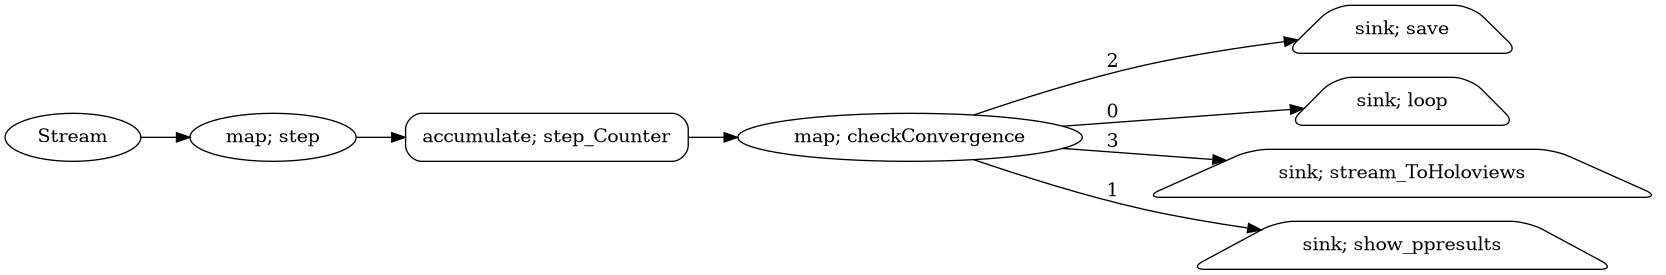

In [23]:
A = np.array([[12., 1., -1.],
              [20., 2.,  1.],
              [ 0., 0., 30.]])

pipeline = sz.Stream(loop=None)
pm_out   = pipeline.map(make_Step(A))\
              .accumulate( step_Counter, returns_state=True, start=0)\
              .map(make_ConvergenceCheck(50,tol=1e-6))
              #.rate_limit(0.5) #appears not to work in jupyter notebook :-(
pm_out.sink(make_LoopBack(50,pipeline));
pm_out.sink(show_ppresults);
save = make_SaveResults()
pm_out.sink(save);

eigenvalue_stream, evolution_plot = eigenvalue_plot()
pm_out.sink( make_StreamToHoloviews(eigenvalue_stream) );

display(pipeline.visualize(rankdir="LR"));

In [24]:
evolution_plot

:DynamicMap   []
   :Layout
      .Curve.Evolution_of_the_Eigenvalue :Curve   [iteration]   (eigenvalue)
      .Curve.Change_in_the_Eigenvector   :Curve   [iteration]   (diff_squared)

In [27]:
pipeline.emit(np.array([1.,2.,1.]))

 50:   [-0.0556 -0.0040  0.9984],  diff2: 4.3376028e-08
 49:   [-0.0555 -0.0038  0.9985],  diff2: 2.0775391e-07
 48:   [-0.0553 -0.0034  0.9985],  diff2: 9.9510593e-07
 47:   [-0.0548 -0.0025  0.9985],  diff2: 4.7668559e-06
 46:   [-0.0537 -0.0007  0.9986],  diff2: 2.283889e-05
 45:   [-0.0513  0.0035  0.9987],  diff2: 0.00010945395
 44:   [-0.0460  0.0125  0.9989],  diff2: 0.0005244913
 43:   [-0.0344  0.0323  0.9989],  diff2: 0.002504442
 42:   [-0.0091  0.0754  0.9971],  diff2: 0.011684946
 41:   [ 0.0457  0.1678  0.9848],  diff2: 0.048527749
 40:   [ 0.1551  0.3491  0.9242],  diff2: 0.1306964
 39:   [ 0.3159  0.6074  0.7289],  diff2: 2.4808554


In [ ]:
save.results[0]

In [28]:
df =pd.DataFrame(
    {'step_n': [i['step_n'] for i in save.results ],
     'e_val':  [i['e_val' ] for i in save.results ],
     'e_vec':  [i['e_vec' ] for i in save.results ],
     'diff2':  [i['diff2' ] for i in save.results ]})
df.head(3)

,step_n,e_val,e_vec,diff2
0,19,30.000000,"[-0.055697683761454876, -0.0041251523217902515...",7.503515e-13
1,18,30.000001,"[-0.05569724744632445, -0.004124404506134243, ...",3.593736e-12
2,17,30.000002,"[-0.05569629258330061, -0.004122767933472809, ...",1.721186e-11


## 3.2 Inverse Power Method

In [29]:
import scipy.linalg as sla

In [30]:
def mk_inverse_power_iteration_step(A):
    lu = sla.lu_factor(A)
    def iteration_step(x):
        x_old = x
        x     = sla.lu_solve( lu, x)        # new_x = A^.inv x <=> solve A new_x = x
        x     = x / np.linalg.norm( x )

        error = np.linalg.norm( x-x_old )
        return x, error

    return iteration_step

In [31]:
A = np.array([[12., 1., -1.],
              [20., 2.,  1.],
              [ 0., 0., 30.]])
inverse_power_iteration_step = mk_inverse_power_iteration_step(A)
plots = GraphicalMonitor3D(15,log_y=True)
plots.plot

Column
    [0] Row(sizing_mode='fixed')
        [0] HoloViews(DynamicMap)
        [1] HoloViews(DynamicMap)
    [1] Row(sizing_mode='stretch_width')
        [0] DataFrame(height=150, sizing_mode='fixed', value=Empty DataFrame
Columns: [..., width=800)

In [32]:
plots.run(inverse_power_iteration_step, x_initial=np.array([1,1,1]), n=100, tol=1e-8)

Step   1: x = ( 0.120428, -0.992615,  0.014597, error =       2.3906442594
Step   2: x = ( 0.085827, -0.996310,  0.000135, error =       0.0376829100
Step   3: x = ( 0.085116, -0.996371,  0.000001, error =       0.0007261680
Step   4: x = ( 0.085101, -0.996372,  0.000000, error =       0.0000153182
Step   5: x = ( 0.085100, -0.996372,  0.000000, error =       0.0000003260
Step   6: x = ( 0.085100, -0.996372,  0.000000, error =       0.0000000069
Converged at step 6


##### **Implementation using streamz**

In [33]:
def inverse_power_method_step( lu, x):
    '''implements a single step of the power method

    Args:
        A  : the np.array matrix
        x  : the current np.array unit vector

    Returns
        diff2, eigval_estimate, eigvec_estimate, where diff2 is the l2 norm of the change in the eigvec_estimate
    '''
    new_x        = sla.lu_solve( lu, x)   # new_x = A^.inv x <=> solve A new_x = x

    normalized_x = new_x / np.linalg.norm(new_x)
    diff         = normalized_x - x

    return normalized_x, diff @ diff

def make_InverseStep(A):
    def inverse_step(x):
        x,diff2 = inverse_power_method_step( inverse_step.lu, x )
        e_val   = estimate_eigenvalue( inverse_step.A, x)
        return { 'e_val': e_val, 'e_vec': x, 'diff2': diff2}
    inverse_step.lu = sla.lu_factor(A)
    inverse_step.A  = A
    return inverse_step

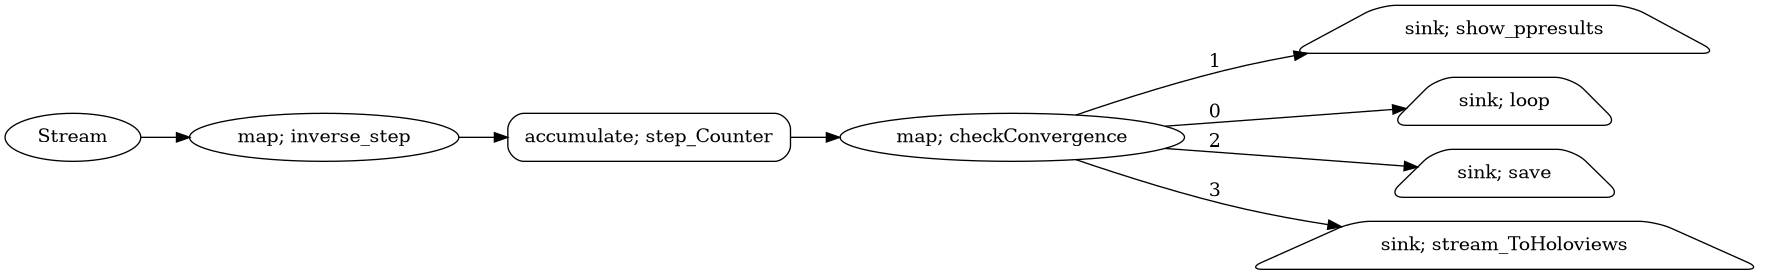

In [34]:
pipeline = sz.Stream(loop=None)
pm_out   = pipeline.map(make_InverseStep(A))\
              .accumulate( step_Counter, returns_state=True, start=0)\
              .map(make_ConvergenceCheck(50,tol=1e-8))
#              .rate_limit(0.5) appears not to work in jupyter notebook :-(
pm_out.sink(make_LoopBack(50,pipeline));
pm_out.sink(show_ppresults);
save = make_SaveResults()
pm_out.sink(save);

eigenvalue_stream, evolution_plot = eigenvalue_plot()
pm_out.sink( make_StreamToHoloviews(eigenvalue_stream) );

display(pipeline.visualize(rankdir="LR"));

In [35]:
evolution_plot

/opt/conda/lib/python3.12/site-packages/holoviews/plotting/plotly/element.py:488: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.12/site-packages/holoviews/plotting/plotly/element.py:488: RuntimeWarning:

divide by zero encountered in log10



:DynamicMap   []
   :Layout
      .Curve.Evolution_of_the_Eigenvalue :Curve   [iteration]   (eigenvalue)
      .Curve.Change_in_the_Eigenvector   :Curve   [iteration]   (diff_squared)

In [36]:
pipeline.emit(np.array([1.,2.,1.]))

  7:   [-0.0851  0.9964  0.0000],  diff2: 4.0084593e-19
  6:   [-0.0851  0.9964  0.0000],  diff2: 8.8397091e-16
  5:   [-0.0851  0.9964  0.0000],  diff2: 1.9486514e-12
  4:   [-0.0851  0.9964  0.0000],  diff2: 4.3005096e-09
  3:   [-0.0850  0.9964  0.0000],  diff2: 9.5315537e-06
  2:   [-0.0820  0.9966  0.0005],  diff2: 0.015479265
  1:   [ 0.0340  0.9984  0.0454],  diff2: 2.8476063


/opt/conda/lib/python3.12/site-packages/holoviews/plotting/plotly/element.py:488: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.12/site-packages/holoviews/plotting/plotly/element.py:488: RuntimeWarning:

invalid value encountered in log10

